In [1]:
# SPDX-FileCopyrightText: 2022 Aleksander Grochowicz
#
# SPDX-License-Identifier: GPL-3.0-or-later

import pandas as pd
from datetime import date
import holidays
import tabulate
from utilities import compute_correlation, compute_rmse, load_regression, compute_cdd_hdd, daily_regression, create_daily_data, create_hourly_data
import copy

In [2]:
import PIL
import warnings 
warnings.filterwarnings("ignore")

# Initiation
## Input data:
- Load data for Europe [from 2006 to 2015, hourly, country-level](europe_demand_2006-2015.csv) based on [ENTSO-E data](../original%20data/europe_demand_2006-2015_original.csv) (where we use [this data from Swissgrid](../original%20data/CH_demand_2010-2015.csv) for 2010 to 2015).
- Temperature data for Europe [from 1980 to 2020, hourly, country-level](europe_temperatures_1980-2020.csv) from ERA5 reanalysis, aggregated by Atlite to hourly values

In [3]:
# Choose years to use for training and test data.
startyear = 2010
endyear = 2014 + 1  # 2010-2014 inclusive.
val_year = 2015
#region = 'europe'
years = list(range(startyear, endyear))
nb_y = len(years)

## Load demand data

## Overwrite Swiss data
The ENTSO-E data for Switzerland is flawed, so we replace it with data from Swissgrid. The next cell corrects the Swiss ENTSO-E data with data from Swissgrid.

In [4]:
# Substitute faulty demand for 'CH' with data from Swissgrid.
# https://www.swissgrid.ch/en/home/operation/grid-data/generation.html#total-energy-consumption
# Energy Statistic for years 2010 to 2015 > Zeitreihen0h15, 'Summe verbrauchte Energie Regelblock Schweiz / Total energy consumption Swiss controlblock'

demand = pd.read_csv('original_data/europe_demand_2006-2015_original.csv', sep = ',', index_col = 0)
demand = demand.rename(columns={"GB": "UK", "GR": "EL"}) 
demand_CH = pd.read_csv('original_data/CH_demand_2010-2015.csv', skiprows=3, index_col = 0)
demand_CH.index = pd.to_datetime(demand_CH.index)
demand_CH = demand_CH.resample('1H').sum()
demand_CH = demand_CH.iloc[:-1]
demand_CH = round((demand_CH / 10**3), 0)

dem_CH = pd.DataFrame()
dem_CH.index = pd.date_range(start = date(2006, 1,1), end = date(2016, 1, 1), freq = '1H')
dem_CH = dem_CH.join(demand_CH)
demand['CH'] = dem_CH['kWh'].values[:-1]
demand = round(demand, 0)
demand.to_csv('processing/europe_demand_2006-2015_corrected.csv')

In [5]:
# Traniing data
demand = pd.read_csv('processing/europe_demand_2006-2015_corrected.csv', index_col = 0, infer_datetime_format=True)
demand.index = pd.to_datetime(demand.index)
demand = demand.loc[str(startyear):str(endyear-1)]

# Test data
demand_val = pd.read_csv('processing/europe_demand_2006-2015_corrected.csv', index_col = 0, infer_datetime_format=True) #for Greece the last hour in 2015 just got the value of the penultimate
demand_val.index = pd.to_datetime(demand_val.index)
demand_val = demand_val.loc[str(val_year)]

## Load temperature data


In [6]:
t = pd.read_csv('original_data/europe_temperatures_2010-2015.csv', index_col = [0,2], infer_datetime_format=True)
temp = {} #create dictionary for each country
for j in t.index.levels[0]:
    temp[j] = t.loc[j]
    temp[j].index = pd.to_datetime(temp[j].index)
    temp[j] = temp[j]

# Same preparation for validation data
t_val = pd.read_csv('original_data/europe_temperatures_2010-2015.csv', index_col = [0,2], infer_datetime_format=True)
demand_val.index = pd.to_datetime(demand_val.index)
t_val = t_val[['temp']]
t_val.index = pd.MultiIndex.from_arrays([t_val.index.get_level_values(0), pd.to_datetime(t_val.index.get_level_values(1))])
t_val = t_val.loc[t_val.index.get_level_values(1).year==val_year]

In [7]:
t_val

temp
CZ 2015-01-01 00:00:00  -2.377241
   2015-01-01 01:00:00  -2.201533
   2015-01-01 02:00:00  -1.994850
   2015-01-01 03:00:00  -1.756580
   2015-01-01 04:00:00  -1.581594
...                           ...
RO 2015-12-31 19:00:00  -7.922575
   2015-12-31 20:00:00  -9.025094
   2015-12-31 21:00:00  -9.273778
   2015-12-31 22:00:00 -10.098438
   2015-12-31 23:00:00 -10.188733

[324120 rows x 1 columns]

## Pick countries to study
Some countries are currently excluded: Iceland, Cyprus, Malta.

In [8]:
demand.columns

Index(['AT', 'BA', 'BE', 'BG', 'CH', 'CS', 'CY', 'CZ', 'DE', 'DK', 'DK_W',
       'EE', 'ES', 'FI', 'FR', 'UK', 'EL', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT',
       'LU', 'LV', 'ME', 'MK', 'NI', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE',
       'SI', 'SK', 'UA_W', 'MT'],
      dtype='object')

In [9]:
c1 = demand.columns
c2 = t.index.levels[0]
all_countries = c1.intersection(c2)
countries = list(all_countries)
countries.remove('IS') 
countries.remove('CY') 
countries.remove('MT')
nb_c = len(countries)

## Check for missing data

In [10]:
# Create dictionary with demand time series for all countries
d = {}
for i in countries:
    d["{0}".format(i)] = pd.DataFrame(demand[i].loc[str(startyear):str(endyear - 1)].copy())

# Determine day of the week  
for i in d.keys():
    d[i] = pd.DataFrame(d[i])
    d[i]['weekday'] = d[i].index.to_series().dt.dayofweek
    d[i].columns = ['demand', 'weekday']

In [11]:
# For chosen countries check for periods of NaN values: https://stackoverflow.com/questions/66426653/count-contiguous-nan-values-and-get-the-start-and-final-date-of-the-nan-contiguo
# This should show missing values in all years, including the validation year.
for c in countries:
    s = demand.index.to_series()
    m2 = demand[c].isna() #creates masks with difference between days is a day, and where the country's demand contains NaN values
    out = s[m2].groupby((~m2).cumsum())\
        .agg(['first', 'last', 'count']).reset_index(drop=True) #aggregate length of periods of missing values first and then group them by the first and last daye as well as the length.
    print('Missing values for',c)
    print(out)

Missing values for AT
                first                last  count
0 2010-03-28 02:00:00 2010-03-28 02:00:00      1
1 2011-03-27 02:00:00 2011-03-27 02:00:00      1
2 2012-03-25 02:00:00 2012-03-25 02:00:00      1
3 2013-03-31 02:00:00 2013-03-31 02:00:00      1
4 2014-03-30 02:00:00 2014-03-30 02:00:00      1
Missing values for BE
                first                last  count
0 2010-03-28 02:00:00 2010-03-28 02:00:00      1
1 2011-03-27 02:00:00 2011-03-27 02:00:00      1
2 2012-03-25 02:00:00 2012-03-25 02:00:00      1
3 2013-03-31 02:00:00 2013-03-31 02:00:00      1
4 2014-03-30 02:00:00 2014-03-30 02:00:00      1
Missing values for BG
                first                last  count
0 2010-03-28 02:00:00 2010-03-28 02:00:00      1
1 2011-03-27 02:00:00 2011-03-27 02:00:00      1
2 2012-03-25 02:00:00 2012-03-25 02:00:00      1
3 2013-03-31 02:00:00 2013-03-31 02:00:00      1
4 2014-03-30 02:00:00 2014-03-30 02:00:00      1
Missing values for CH
Empty DataFrame
Columns: [firs

In [12]:
# Dictionary with demand data frames for each country
d_val = {}
for i in countries:
    d_val["{0}".format(i)] = pd.DataFrame(demand_val[i].loc[str(val_year)].copy())

# Determine day of the week
for i in d.keys():
    d_val[i] = pd.DataFrame(d_val[i])
    d_val[i] = d_val[i].fillna(method = 'bfill')
    d_val[i]['weekday'] = d_val[i].index.to_series().dt.dayofweek
    d_val[i].columns = ['demand', 'weekday']

# Dictionary with temperature for each country 
temp_val = {} #create dictionary for each country
for j in countries:
    temp_val[j] = t_val.loc[j]
    temp_val[j].index = pd.to_datetime(temp_val[j].index)

## Add holidays
Those seem to work particularly well for some Central European countries, e.g. Germany. Generally not so well for orthodox countries due to the different calendar. Additionally to the official holidays, add the days from December 24 to January 2.

In [13]:
countries

['AT',
 'BE',
 'BG',
 'CH',
 'CZ',
 'DE',
 'DK',
 'EE',
 'ES',
 'FI',
 'FR',
 'UK',
 'EL',
 'HR',
 'HU',
 'IE',
 'IT',
 'LT',
 'LU',
 'LV',
 'ME',
 'MK',
 'NL',
 'NO',
 'PL',
 'PT',
 'RO',
 'RS',
 'SE',
 'SI',
 'SK']

In [14]:
list_holidays = {}
yrs = years.copy()
for c in countries:
    if c == 'EL':
        list_holidays[c] = holidays.CountryHoliday('GR', years = yrs)
    else:
        try:
            list_holidays[c] = holidays.CountryHoliday(c, years = yrs)
        except KeyError:
            list_holidays[c] = holidays.HolidayBase() #if no holidays are available, e.g. ME, MK        

Add some holidays that have shown to have lower load.

In [15]:
julian = ['ME', 'MK', 'RS']
gregorian = countries.copy()
for i in countries:
    if i in julian:
        gregorian.remove(i)

# Add last week of the year as holidays.
for y in list(range(2010, 2016)):
    for i in gregorian:
        # Add the days between Christmas Eve and New Year's Eve as holidays.
        list_holidays[i].append(date(y,1,2))
        list_holidays[i].append(list(pd.date_range(start = date(y, 12, 24), end = date(y, 12, 31), freq = '1D')))
    for i in julian:
        # Add Orthodox Christmas.
        list_holidays[i].append(list(pd.date_range(start = date(y, 1, 6), end = date(y, 1, 8), freq = '1D')))
        

# Try to do directly the second regression


In [16]:
# Resample to daily data and add holidays.
# Create data frames for each country to prepare regression 
dt = {}
for i in countries:
    dt[i] = pd.DataFrame(d[i].loc[str(startyear):str(endyear - 1)])
    dt[i].fillna(method = 'bfill')
    dt[i]['temp'] = temp[i]['temp']
    dt[i]['weekday'] = d[i]['weekday']
    dt[i]['holiday'] = False

# Add holidays
dt_with_holidays = dt.copy()
for i in dt_with_holidays.keys():
    for j in dt_with_holidays[i].index:
        if j in list_holidays[i]:
            dt_with_holidays[i].at[j, 'holiday'] = True

# Same for validation year (use the same holidays)
dt_val = {}
for i in countries:
    dt_val[i] = pd.DataFrame(d_val[i].loc[str(val_year)])
    dt_val[i].fillna(method = 'bfill')
    dt_val[i]['temp'] = temp_val[i]['temp']
    dt_val[i]['weekday'] = d_val[i]['weekday']
    dt_val[i]['holiday'] = False

dt_with_holidays_val = dt_val.copy()
for i in dt_with_holidays_val.keys():
    for j in dt_with_holidays_val[i].index:
        if j in list_holidays[i]:
            dt_with_holidays_val[i].at[j, 'holiday'] = True

# Add weekly profiles
data_daily_values = dt.copy()
for i in dt.keys():
    data_daily_values[i] = data_daily_values[i].resample('1D').mean()

In [17]:
# Consider heating and cooling degree days
daily_hc = compute_cdd_hdd(data_daily_values, countries, threshold_hdd = 17, threshold_cdd = 17)
# Do the same for validation
data_daily_values_val = {}
for i in countries:
    data_daily_values_val[i] = dt_val[i].resample('1D').mean()

daily_hc_val = compute_cdd_hdd(data_daily_values_val, countries, threshold_hdd = 17, threshold_cdd = 17)

In [18]:
# Regression on temperature
par_hc_l, temp_hc_l, aic_hc_l, trend_hc_l, fourier_hc_l = daily_regression(place=countries,dict = dt, weekly_regression = daily_hc, daily = False, trend = 0, fourier_component = 0)

BE 8 has p-value 0.052242811417506634 therefore we consider it statistically insignificant and set the parameter to 0
DK 8 has p-value 0.08097206552296508 therefore we consider it statistically insignificant and set the parameter to 0
UK 8 has p-value 0.42047020381209665 therefore we consider it statistically insignificant and set the parameter to 0
LU 8 has p-value 0.5532066994548994 therefore we consider it statistically insignificant and set the parameter to 0


In [19]:
# Create artificial daily data
artificial_data, days, first_day = create_daily_data(par_hc_l, trend_hc_l, daily_hc, temp_hc_l, countries, start = startyear, end = endyear, validation_days = 0)


In [21]:
save_files = True # if True, save all values that are being generated
if save_files:
    par_hc_l.to_csv(f"processing/justine_europe_parameters_days_of_week_{startyear}-{endyear-1}_17.csv")
    trend_hc_l.T.to_csv(f'processing/justine_europe_parameters_trend_{startyear}-{endyear-1}_17.csv')
    temp_hc_l.T.to_csv(f'processing/justine_europe_parameters_temp_{startyear}-{endyear-1}_17.csv')

# Test the regression coefficients

In [22]:
reg_justine_days = pd.read_csv('processing/justine_europe_parameters_days_of_week_2010-2014_17.csv',index_col = [0])

In [23]:
artificial_data

{'AT': datetime
 2010-01-01    6785.334847
 2010-01-02    7039.105224
 2010-01-03    7358.274259
 2010-01-04    9067.850657
 2010-01-05    9159.254588
                  ...     
 2014-12-27    7199.349245
 2014-12-28    7232.944570
 2014-12-29    7451.475118
 2014-12-30    7389.918572
 2014-12-31    7263.004669
 Freq: D, Length: 1826, dtype: float64,
 'BE': datetime
 2010-01-01    10091.695543
 2010-01-02    10132.572670
 2010-01-03    10297.399940
 2010-01-04    11816.027452
 2010-01-05    11843.783147
                   ...     
 2014-12-27     9764.607136
 2014-12-28    10350.159880
 2014-12-29     9871.212727
 2014-12-30     9650.141819
 2014-12-31     9629.858849
 Freq: D, Length: 1826, dtype: float64,
 'BG': datetime
 2010-01-01    4007.260241
 2010-01-02    4278.405924
 2010-01-03    4936.361845
 2010-01-04    5455.113119
 2010-01-05    5466.995721
                  ...     
 2014-12-27    5063.596075
 2014-12-28    5095.426502
 2014-12-29    5105.155558
 2014-12-30    5723.0145

# Not used : Create hourly artificial data

In [58]:
artificial_hourly = create_hourly_data(artificial_data, data_par_weekly_reordered, dt, first_day, countries, startyear, endyear)

# Justification

In [33]:
# Compute correlation and random mean square error.
frequencies = ['1H', '1D']
corr_hourly = compute_correlation(data = artificial_hourly, data_comparison = dt, column = None, place = countries, frequency = frequencies)
rmse_hourly = compute_rmse(artificial_hourly, dt, column = None, place = countries, frequency = frequencies)


# Validation

In [34]:
# Create artificial data for the validation period.
# Daily
artificial_data_val, days_val, first_day_val = create_daily_data(par_hc_l, trend_hc_l, daily_hc_val, temp_hc_l, countries,start = val_year, end = val_year+1, validation_days = days)
# Hourly
artificial_hourly_val = create_hourly_data(artificial_data_val, data_par_weekly_reordered, dt_val, firstday = first_day_val, place=countries, start = val_year, end = val_year+1)

In [35]:
# If the Swiss data is manually added it leads to some NaN values, so we fill them with 0 for the validation)
for i in countries:
    dt_val[i] = dt_val[i].fillna(0)

# Compute the correlation between the artificial and validation data
corr_val = compute_correlation(data = artificial_hourly_val, 
                               data_comparison = dt_val, 
                               column = None, 
                               place = countries, 
                               frequency = frequencies)
# Compute the RMSE for artificial and validation data
rmse_val = compute_rmse(artificial_hourly_val, dt_val, column = None, place = countries, frequency = frequencies)



In [36]:
# Compute the hourly average RMSE in percent.
perc_error = {}
for i in countries:
    perc_error[i] = round(100 * (rmse_val.loc[i]['1H']/artificial_hourly_val[i].mean()),1)
perc_error = pd.DataFrame.from_dict(perc_error).T
perc_error.columns = ['hourly avg. RMSE in percent']


In [37]:
# Print the validation tables for the GitHub README.

In [38]:
validation = pd.concat([pd.DataFrame(corr_val['1H'].droplevel(1)),pd.DataFrame(rmse_val['1H'].droplevel(1)),perc_error],axis=1)
validation.columns=["Corr", "RMSE", "Hourly avg. RMSE in %"]

In [44]:
validation.sort_values(by='Hourly avg. RMSE in %')

,Corr,RMSE,Hourly avg. RMSE in %
SK,0.94,149.5,4.7
PL,0.96,820.5,4.9
LT,0.96,62.6,5.1
FI,0.94,482.2,5.2
HU,0.95,249.0,5.5
CZ,0.95,405.4,5.7
DE,0.97,3295.7,5.7
BE,0.94,557.8,5.9
SE,0.95,905.2,5.9
NL,0.94,772.1,6.0


In [52]:
demand['EL'].iloc[:-100]

datetime
2006-01-01 00:00:00    5058.0
2006-01-01 01:00:00    4924.0
2006-01-01 02:00:00    4618.0
2006-01-01 03:00:00    4344.0
2006-01-01 04:00:00    4195.0
                        ...  
2015-12-27 15:00:00    5702.0
2015-12-27 16:00:00    6210.0
2015-12-27 17:00:00    6746.0
2015-12-27 18:00:00    6796.0
2015-12-27 19:00:00    6703.0
Name: EL, Length: 87548, dtype: float64

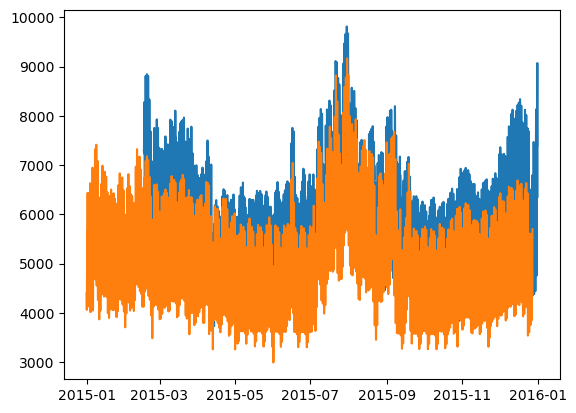

In [55]:
import matplotlib.pyplot as plt
plt.plot(demand['EL'].iloc[80000:])
plt.plot(artificial_hourly_val['EL'][:-100])


In [43]:
tabulate.tabulate(validation.T, validation.index)

'                           AT      BE      BG      CH      CZ       DE      DK     EE       ES      FI       FR       UK      EL      HR      HU      IE       IT     LT     LU     LV    ME     MK      NL       NO      PL      PT      RO      RS      SE     SI      SK\n---------------------  ------  ------  ------  ------  ------  -------  ------  -----  -------  ------  -------  -------  ------  ------  ------  ------  -------  -----  -----  -----  ----  -----  ------  -------  ------  ------  ------  ------  ------  -----  ------\nCorr                     0.96    0.94    0.88    0.92    0.95     0.97    0.94   0.96     0.94    0.94     0.94     0.92    0.89    0.93    0.95    0.93     0.95   0.96   0.74   0.96   0.8   0.93    0.94     0.93    0.96    0.94    0.92    0.95    0.95   0.94    0.94\nRMSE                   514.8   557.8   426.9   449     405.4   3295.7   302.6   56.6   1969.5   482.2   3946.4   3461     941.7   138.3   249     226.6   3007.1   62.6   95.3   52.5   53.6  79

In [40]:
# Additional validation comparing to JRC-IDEES electric heating demand

# Create data where heating is set to 0, i.e. obtain the electric demand that is temperature-independent + cooling demand
no_temperature = {}
for i in countries:
    no_temperature[i] = daily_hc_val[i].copy(deep=True)
    no_temperature[i]['heating'] = 0


artificial_data_nt, days, first_day = create_daily_data(par_hc_l, trend_hc_l, no_temperature, temp_hc_l, countries, start = val_year, end = val_year+1, validation_days = days)

artificial_hourly_nt = create_hourly_data(artificial_data_nt, data_par_weekly_reordered, dt_val, first_day, countries, start = val_year, end = val_year+1)

#all hourly values are in MW
heating_yearly = {}
non_eu_countries = ['CH', 'ME', 'MK', 'NO', 'RS']
eu_countries = [i for i in countries if (i not in non_eu_countries)]
for i in eu_countries:
    heating_yearly[i] = round(((artificial_hourly_val[i] - artificial_hourly_nt[i])/10**6).sum(),1)

c:\Users\JD278300\Documents\Stage\Create data\multidecade-data\load data\utilities.py:408: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  artificial_daily[i][j] = (
c:\Users\JD278300\Documents\Stage\Create data\multidecade-data\load data\utilities.py:415: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  artificial_daily[i][j] = (
c:\Users\JD278300\Documents\Stage\Create data\multidecade-data\load data\utilities.py:459: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  0 + artificial[i][j // 24] * weekly_profile[i].iloc[k]


Paste in [JRC-IDEES heating demand](../original%20data/jrc_2015_electric_heating_demand).

In [42]:
space_heating = {'AT': 335+48,
'BE': 251+506,
'BG': 97+110,
'CZ': 251+367,
'DE': 2250+1177,
'DK': 108+40,
'EE': 11+85,
'EL': 129+263,
'ES': 939+651,
'FI': 676+528,
'FR': 2776+2966,
'HR': 36+74,
'HU': 88+57,
'IE': 137+60,
'IT': 381+1435,
'LT': 19+22,
'LU': 17+32,
'LV': 7+37,
'NL': 290+285,
'PL': 196+896,
'PT': 18+322,
'RO': 148+27,
'SE': 1448+590,
'SI': 42+47,
'SK': 80+81,
'UK': 2791+1296}

for i in space_heating.keys():
    space_heating[i] = 1.163e-2*space_heating[i] #given data is in ktoe, so multiply it by 1.163e-2 to get TWh

In [43]:
#Compare JRC electricity for space heating to artificial electric heating data:
explained = {}
for i in eu_countries:
    if space_heating[i] == 0:
        explained[i] = None
    else:
        explained[i] = round(heating_yearly[i]/space_heating[i],2)*100
perc_explained = pd.DataFrame.from_dict(explained, orient = 'index', columns = ['detected electric heating demand in %']).T

In [44]:
tabulate.tabulate(perc_explained.values - 100, perc_explained.columns, tablefmt="github")

'|   AT |   BE |   BG |   CZ |   DE |   DK |   EE |   ES |   FI |   FR |   UK |   EL |   HR |   HU |   IE |   IT |   LT |   LU |   LV |   NL |   PL |   PT |   RO |   SE |   SI |   SK |\n|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|\n|   35 |  -31 |  112 |  -15 |  -39 |   86 |   16 |  -30 |    6 |   25 |  -31 |  -10 |    9 |   -5 |   22 |  -54 |   68 |  -65 |   56 |  -21 |  -31 |  -42 |   92 |   40 |  -42 |    7 |'